# 1 FEATURE , PAST 10 YEAR , NEXT DAY PREDICTION WINDO SIZE=6

In [2]:
!pip install meteostat

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Flatten,BatchNormalization
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


2025-05-11 13:16:02.393244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746969362.606536      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746969362.668041      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="jainam")

# Example city
city = "Ahmedabad, India"

location = geolocator.geocode(city)

if location:
    print(f"City: {city}")
    print(f"Latitude: {location.latitude}, Longitude: {location.longitude}")
else:
    print(f"Could not find coordinates for {city}")


In [ ]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2014, 6, 1)
end = datetime.datetime(2024, 6, 1)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


In [ ]:
temperature_avg=data[["tavg"]]


In [ ]:
print("TOTAL NULL VALUES IN DATASET:",temperature_avg.isnull().sum())

In [ ]:
temperature_avg.dropna(inplace=True)

In [ ]:
temperature_avg.describe()

In [ ]:
temperature_avg.info()

In [ ]:
temperature_avg_seq=temperature_avg.values
print(temperature_avg_seq,temperature_avg_seq.shape)

In [ ]:
len(temperature_avg_seq)

In [3]:
def plot_loss_curves(history):
    """
    Plots the loss curves of a model
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['mae']
    val_accuracy = history.history['val_mae']

    epochs = range(len(history.history['loss']))


    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
window_size=6
X=[]
Y=[]
for i in range(len(temperature_avg_seq)-window_size):
  X.append(temperature_avg_seq[i:i+window_size])
  Y.append(temperature_avg_seq[i+window_size])


In [ ]:
X=np.array(X)
Y=np.array(Y)


In [ ]:
print("X Shape",X.shape)
print("Y Shape",Y.shape)


In [ ]:
X_scaler=MinMaxScaler()
Y_scaler=MinMaxScaler()

X_flat = np.array(X).reshape(-1, 1)
Y_flat = np.array(Y).reshape(-1, 1)

X_scaled=X_scaler.fit_transform(X_flat).reshape(len(X),6,1)
Y_scaled=Y_scaler.fit_transform(Y_flat).reshape(len(Y),1)

In [ ]:
print("X_scaled Shape",X_scaled.shape)
print("Y_scaled Shape",Y_scaled.shape)


In [ ]:
naive_model=Sequential()
naive_model.add(LSTM(128,return_sequences=True,input_shape=(window_size,1)))
naive_model.add(Dropout(0.2))
naive_model.add(LSTM(64,return_sequences=True))
naive_model.add(Dropout(0.2))
naive_model.add(LSTM(32))
naive_model.add(Dropout(0.2))
naive_model.add(Dense(1))

In [ ]:
naive_model.summary()

In [ ]:
naive_model.compile(optimizer="adam",loss="mse",metrics=["mae"])

In [ ]:
history=naive_model.fit(np.array(X_scaled).reshape(-1,window_size,1),Y_scaled,epochs=100,batch_size=16,validation_split=0.2)

In [ ]:
plot_loss_curves(history)

In [ ]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 6, 1)
end = datetime.datetime(2024, 12, 1)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


In [ ]:
print(data.shape)

In [ ]:
next_6_months_temp=data["tavg"]


In [ ]:
plt.plot(next_6_months_temp.values.flatten())

In [ ]:
location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 5, 26)
end = datetime.datetime(2024, 5, 31)

# Get historical data
data_for_model = Daily(location, start, end)
data_for_model = data_for_model.fetch()

print(data_for_model)


In [ ]:
data_for_model["tavg"].values

In [ ]:
data_for_model=X_scaler.transform(np.array(data_for_model["tavg"].values).reshape(-1,1))


In [ ]:
data_for_model=data_for_model.reshape(1,6,1)

In [ ]:
copied=data_for_model.copy()
copied=copied[1:]
copied = np.append(copied, 1.2)
copied

In [ ]:
data_for_model=data_for_model.flatten()

In [ ]:
data_for_model

In [ ]:
output=[]
for i in range(184):
    print(data_for_model)

    prediction = naive_model.predict(np.array(data_for_model).reshape(-1, window_size, 1))
    prediction_original = Y_scaler.inverse_transform(prediction.reshape(1, -1))
    output.append(prediction_original[0, 0])
    data_for_model = np.append(data_for_model[1:], prediction)

In [ ]:
next_6_months_temp=list(next_6_months_temp.values)

In [ ]:
print("Len Output:",len(output))
print("Len next_6_months_temp:",len(next_6_months_temp))


In [ ]:

# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(list(next_6_months_temp), label="Actual Temperature")
plt.plot(list(output), label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [ ]:
from sklearn.metrics import r2_score
r2_score(list(next_6_months_temp),output)

In [ ]:
naive_model.save("naive_model.h5")

# 1 FEATURE , PAST 27 YEAR , NEXT DAY PREDICTION WINDO SIZE=100

In [ ]:
"""
JUST CHANGE data[feature] : feature with tmin,tmax,tavg 
                            and change Scaler with Standard Scaler and MinMax Scaler
                            remain all other code same 

And You wil get result as i got which i mentioned in All model evalution portion.

"""

In [ ]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(1990, 6, 1)
end = datetime.datetime(2024, 6, 1)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


In [ ]:
temperature_avg=data["tmin"]

In [ ]:
print("TOTAL NULL VALUES IN DATASET:",temperature_avg.isnull().sum())

In [ ]:
temperature_avg.dropna(inplace=True)

In [ ]:
temperature_avg.describe()

In [ ]:
temperature_avg.info()

In [ ]:
temperature_avg_seq=temperature_avg.values
print(temperature_avg_seq,temperature_avg_seq.shape)

In [ ]:

window_size=100

X=[]
Y=[]
for i in range(len(temperature_avg_seq)-window_size):
  X.append(temperature_avg_seq[i:i+window_size])
  Y.append(temperature_avg_seq[i+window_size])

In [ ]:
X=np.array(X)
Y=np.array(Y)

In [ ]:
print("X Shape",X.shape)
print("Y Shape",Y.shape)


In [ ]:
X

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:
print("X_train Shape",X_train.shape)
print("X_test Shape",X_test.shape)
print("Y_train Shape",Y_train.shape)
print("Y_test Shape",Y_test.shape)


In [ ]:
X_train

In [ ]:
from sklearn.preprocessing import StandardScaler
MinMax=MinMaxScaler()
X_train_Scaled=MinMax.fit_transform(X_train.reshape(-1,1))
X_test_Scaled=MinMax.transform(X_test.reshape(-1,1))

In [ ]:
X_train=X_train_Scaled.reshape(X_train.shape[0],100)

In [ ]:
X_test=X_test_Scaled.reshape(X_test.shape[0],100)

In [ ]:
print("X_train Shape",X_train.shape)
print("X_test Shape",X_test.shape)
print("Y_train Shape",Y_train.shape)
print("Y_test Shape",Y_test.shape)


In [ ]:
maxLength=6
upgraded_naive_model=Sequential()
upgraded_naive_model.add(LSTM(128,return_sequences=True,input_shape=(window_size,1)))
upgraded_naive_model.add(Dropout(0.2))
upgraded_naive_model.add(LSTM(100,return_sequences=True))
upgraded_naive_model.add(Dropout(0.2))
upgraded_naive_model.add(LSTM(100,return_sequences=True))
upgraded_naive_model.add(Dropout(0.2))
upgraded_naive_model.add(LSTM(100))
upgraded_naive_model.add(Dropout(0.2))

upgraded_naive_model.add(Dense(64,activation="relu"))
upgraded_naive_model.add(Dropout(0.2))


upgraded_naive_model.add(Dense(1))


In [ ]:
upgraded_naive_model.summary()

In [ ]:
upgraded_naive_model.compile(optimizer="adam",loss="mse",metrics=["mae"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "temperature_best_min_MinMax.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

In [ ]:
X_test.shape, Y_test.shape

In [ ]:
history=upgraded_naive_model.fit(np.array(X_train).reshape(-1,window_size,1),Y_train,epochs=50,batch_size=16,validation_data=(X_test,Y_test),callbacks=[checkpoint])

In [ ]:
plot_loss_curves(history)

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_min_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 6, 1)
end = datetime.datetime(2024, 6, 30)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


In [ ]:
print(data.shape)

In [ ]:
next_6_months_temp=data["tmin"]


In [ ]:
plt.plot(next_6_months_temp.values.flatten())

In [ ]:
location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 2, 22)
end = datetime.datetime(2024, 5, 31)

# Get historical data
data_for_model = Daily(location, start, end)
data_for_model = data_for_model.fetch()

print(data_for_model)


In [ ]:
data_for_model["tmin"].values

In [ ]:
data_for_model=MinMax.transform(np.array(data_for_model["tmin"].values).reshape(-1,1))


In [ ]:
data_for_model=data_for_model.reshape(1,100,1)

In [ ]:
data_for_model=data_for_model.flatten()
data_for_model

In [ ]:
copied=data_for_model.copy()
copied=copied[1:]
copied = np.append(copied, 1.2)
copied

In [ ]:
output=[]
for i in range(30):
    print(data_for_model)

    prediction = best_model.predict(np.array(data_for_model).reshape(-1, window_size, 1))
    
    output.append(prediction)
    data_for_model = np.append(data_for_model[1:], prediction)

In [ ]:
next_6_months_temp=list(next_6_months_temp.values)

In [ ]:
print("Len Output:",len(output))
print("Len next_6_months_temp:",len(next_6_months_temp))


In [ ]:
list(np.array(output).flatten())

In [ ]:

# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(list(next_6_months_temp), label="Actual Temperature")
plt.plot(list(np.array(output).flatten()), label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [ ]:
from sklearn.metrics import r2_score,mean_squared_error
mean_squared_error(list(next_6_months_temp),list(np.array(output).flatten()))

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
len(y_prediction_x)

In [ ]:
y_pred_final=[]
for i in y_prediction_x:
  # print(i)
  y_pred_final.append(MinMax.inverse_transform(i.reshape(-1,1))[0,0])


In [ ]:
y_true_final=[]

for i in Y_test:
  # print(i)
  y_true_final.append(MinMax_Loaded.inverse_transform(np.array(i).reshape(-1,1))[0,0])


In [ ]:
y_true_final[0], y_pred_final[0], Y_test[0],y_prediction_x[0]

In [ ]:
len(y_true_final)

In [ ]:
mean_squared_error(Y_test,y_prediction_x)

In [ ]:
len(y_true_final)

In [ ]:


# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(Y_test, label="Actual Temperature")
plt.plot(y_prediction_x, label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [ ]:
import pickle as pkl

pkl.dump(MinMax,open("MinMaxScaler_min.pkl",'wb'))

In [ ]:
MinMax_Loaded=pkl.load(open("/kaggle/working/MinMax_Avg.pkl","rb"))

# 4 FEATURES , 100 WINDOW SIZE ,BATCH SIZE=32 , NEXT PREDICTION

In [57]:
import numpy as np

In [115]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 12, 31)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2000-01-01  21.8  12.5  29.6   0.0   NaN    NaN   NaN   NaN     NaN   NaN
2000-01-02  21.4  15.1  30.0   0.0   NaN    NaN   NaN   NaN     NaN   NaN
2000-01-03  20.4   NaN  30.3   0.0   NaN    NaN   NaN   NaN     NaN   NaN
2000-01-04  18.5  11.8  30.2   0.0   NaN    NaN   NaN   NaN     NaN   NaN
2000-01-05  20.7   9.6  29.4   0.0   NaN    NaN   NaN   NaN     NaN   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-12-27  21.8  19.0  27.0   0.0   NaN  308.0   6.5   NaN  1015.3   NaN
2024-12-28  20.3  16.0  25.8   0.0   NaN  343.0   6.4   NaN  1016.3   NaN
2024-12-29  19.9  15.0  25.0   0.0   NaN   25.0  15.5   NaN  1017.5   NaN
2024-12-30  19.5  14.0  26.4   0.0   NaN   22.0   9.4   NaN  1017.0   NaN
2024-12-31  20.5  14.0  27.4   0.0   NaN   14.0   6.5   NaN  1016.8   NaN

[9132 rows x 10 columns]


In [116]:
data.reset_index(inplace=True)

In [117]:
target_column="tavg"

In [118]:
temperature_max=data[["time",target_column]]

In [119]:
temperature_max['month'] = temperature_max['time'].dt.month
temperature_max['dayofyear'] = temperature_max['time'].dt.dayofyear  


seasonal_mean = temperature_max.groupby('month')[target_column].transform('mean') 
temperature_max[target_column] = temperature_max[target_column].fillna(seasonal_mean) 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [120]:
print("TOTAL NULL VALUES IN DATASET:",temperature_max.isnull().sum())

TOTAL NULL VALUES IN DATASET: time         0
tavg         0
month        0
dayofyear    0
dtype: int64


In [121]:
temperature_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9132 entries, 0 to 9131
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       9132 non-null   datetime64[ns]
 1   tavg       9132 non-null   float64       
 2   month      9132 non-null   int32         
 3   dayofyear  9132 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 214.2 KB


In [122]:
_## we use another 3 feature sin of year and cos of year

# "sin_day_of_year"-->Sine transformation for seasonality	Float (between -1 and 1)	0.75
# "cos_day_of_year"-->Cosine transformation for seasonality	Float (between -1 and 1)	-0.43

temperature_max['sin_day_of_year'] = np.round(np.sin(2 * np.pi * temperature_max['dayofyear'] / 365),4)
temperature_max['cos_day_of_year'] = np.round(np.cos(2 * np.pi * temperature_max['dayofyear'] / 365),4)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [123]:
temperature_max

,time,tavg,month,dayofyear,sin_day_of_year,cos_day_of_year
0,2000-01-01,21.8,1,1,0.0172,0.9999
1,2000-01-02,21.4,1,2,0.0344,0.9994
2,2000-01-03,20.4,1,3,0.0516,0.9987
3,2000-01-04,18.5,1,4,0.0688,0.9976
4,2000-01-05,20.7,1,5,0.0860,0.9963
...,...,...,...,...,...,...
9127,2024-12-27,21.8,12,362,-0.0516,0.9987
9128,2024-12-28,20.3,12,363,-0.0344,0.9994
9129,2024-12-29,19.9,12,364,-0.0172,0.9999
9130,2024-12-30,19.5,12,365,0.0000,1.0000


In [124]:
temperature_max_processed=temperature_max[[target_column,"sin_day_of_year","cos_day_of_year","month"]]

In [125]:
# temperature_max_processed[['tmax', 'sin_day_of_year', 'cos_day_of_year', 'month']].iloc[:100].values.shape  # shape (100, 4)
temperature_max_processed[target_column].iloc[100]  # scalar (next day's tmax)

31.5

In [126]:
window_size=100

X=[]
Y=[]

for i in range(len(temperature_max_processed)-window_size):
    X.append(temperature_max_processed[[target_column, 'sin_day_of_year', 'cos_day_of_year', 'month']].iloc[i:i+window_size].values)
    Y.append(temperature_max_processed[target_column].iloc[i+window_size])

In [127]:
X=np.array(X)
Y=np.array(Y)


In [128]:
print("X Shape:",X.shape)
print("Y Shape:",Y.shape)


X Shape: (9032, 100, 4)
Y Shape: (9032,)


# SPLITING THE DATA INTO TRAIN AND TEST

In [131]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [132]:
print("X_train Shape",X_train.shape)
print("X_test Shape",X_test.shape)
print("Y_train Shape",Y_train.shape)
print("Y_test Shape",Y_test.shape)


X_train Shape (7225, 100, 4)
X_test Shape (1807, 100, 4)
Y_train Shape (7225,)
Y_test Shape (1807,)


In [133]:
from sklearn.preprocessing import StandardScaler
Standard=StandardScaler()
X_train_Scaled=Standard.fit_transform(X_train.reshape(-1,1))
X_test_Scaled=Standard.transform(X_test.reshape(-1,1))



In [134]:
X_train=X_train_Scaled.reshape(X_train.shape[0],100,4)
X_test=X_test_Scaled.reshape(X_test.shape[0],100,4)

In [ ]:
Y_train=Y_train_Scaled
Y_test=Y_test_Scaled

In [135]:
print("X_train Shape",X_train.shape)
print("X_test Shape",X_test.shape)
print("Y_train Shape",Y_train.shape)
print("Y_test Shape",Y_test.shape)


X_train Shape (7225, 100, 4)
X_test Shape (1807, 100, 4)
Y_train Shape (7225,)
Y_test Shape (1807,)


In [84]:
print(X_train[0],Y_train[0])

[[ 1.96122915e+00 -7.93926464e-01 -8.40183336e-01  5.60084171e-04]
 [ 1.95057334e+00 -7.95556803e-01 -8.39330871e-01  5.60084171e-04]
 [ 2.07844306e+00 -7.97165830e-01 -8.38457094e-01  5.60084171e-04]
 [ 2.02516401e+00 -7.98753546e-01 -8.37551350e-01  1.07118186e-01]
 [ 2.00385239e+00 -8.00341262e-01 -8.36624295e-01  1.07118186e-01]
 [ 1.95899211e+00 -8.01897010e-01 -8.35654616e-01  1.07118186e-01]
 [ 1.95899211e+00 -8.03442102e-01 -8.34674282e-01  1.07118186e-01]
 [ 1.95899211e+00 -8.04976539e-01 -8.33661980e-01  1.07118186e-01]
 [ 1.96122915e+00 -8.06489664e-01 -8.32617710e-01  1.07118186e-01]
 [ 1.95899211e+00 -8.07981477e-01 -8.31552129e-01  1.07118186e-01]
 [ 1.87598267e+00 -8.09451979e-01 -8.30465237e-01  1.07118186e-01]
 [ 1.95899211e+00 -8.10911825e-01 -8.29346377e-01  1.07118186e-01]
 [ 1.84401524e+00 -8.12350360e-01 -8.28206205e-01  1.07118186e-01]
 [ 1.91860591e+00 -8.13767582e-01 -8.27044722e-01  1.07118186e-01]
 [ 1.95899211e+00 -8.15163493e-01 -8.25851271e-01  1.07118186e

# IMPORTING IMPORTANT LIBRARIES FOR MAKING DEEP LEARNING MODEL WITH LSTM

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Flatten,BatchNormalization
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [137]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint(
    "temperature_avg_Standard.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

earlyStop=EarlyStopping(
    monitor="val_loss",
    patience=3
)

# INITIALIZING MODEL STRUCTURE

In [138]:
maxLength=6
upgraded_naive_model1=Sequential()
upgraded_naive_model1.add(LSTM(128,return_sequences=True,input_shape=(window_size,4)))
upgraded_naive_model1.add(BatchNormalization())
upgraded_naive_model1.add(Dropout(0.2))

upgraded_naive_model1.add(LSTM(100,return_sequences=True))
upgraded_naive_model1.add(BatchNormalization())
upgraded_naive_model1.add(Dropout(0.2))

upgraded_naive_model1.add(LSTM(100,return_sequences=True))
upgraded_naive_model1.add(BatchNormalization())
upgraded_naive_model1.add(Dropout(0.2))

upgraded_naive_model1.add(LSTM(100))
upgraded_naive_model1.add(BatchNormalization())
upgraded_naive_model1.add(Dropout(0.2))

upgraded_naive_model1.add(Dense(128,activation="relu"))
upgraded_naive_model1.add(BatchNormalization())
upgraded_naive_model1.add(Dropout(0.2))

upgraded_naive_model1.add(Dense(64,activation="relu"))
upgraded_naive_model1.add(BatchNormalization())
upgraded_naive_model1.add(Dropout(0.2))

upgraded_naive_model1.add(Dense(1))


In [139]:
upgraded_naive_model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100, 128)            │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100, 100)            │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 100, 100)            │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 100, 100)            │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 344,225 (1.31 MB)

 Trainable params: 342,985 (1.31 MB)

 Non-trainable params: 1,240 (4.84 KB)

In [140]:
upgraded_naive_model1.compile(optimizer="adam",loss="mse",metrics=["mae"])

In [141]:
history=upgraded_naive_model1.fit(np.array(X_train).reshape(-1,window_size,4),Y_train,epochs=50,batch_size=32,validation_data=(X_test,Y_test),callbacks=[checkpoint])

Epoch 1/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 734.1039 - mae: 26.8905
Epoch 1: val_loss improved from inf to 870.31177, saving model to temperature_avg_Standard.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 733.2816 - mae: 26.8748 - val_loss: 870.3118 - val_mae: 29.1367
Epoch 2/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 376.7950 - mae: 18.8718
Epoch 2: val_loss improved from 870.31177 to 198.83035, saving model to temperature_avg_Standard.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 375.2871 - mae: 18.8242 - val_loss: 198.8304 - val_mae: 13.6674
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 47.6895 - mae: 5.8897
Epoch 3: val_loss improved from 198.83035 to 22.90940, saving model to temperature_avg_Standard.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 47.6202 - mae: 5.8840 - val_loss: 22.9094 - val_mae: 4.2340
Epoch 4/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14.7366 - mae: 3.0223
Epoch 4: val_loss impro

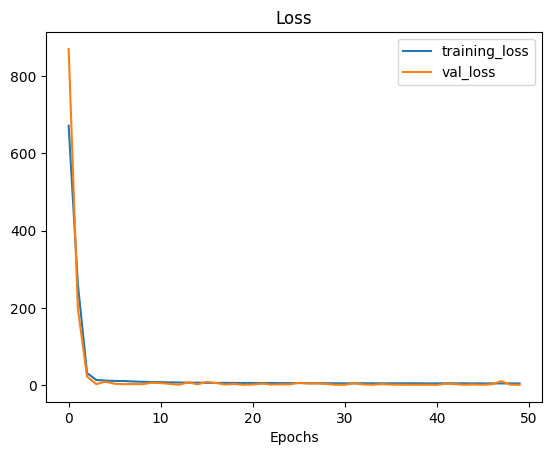

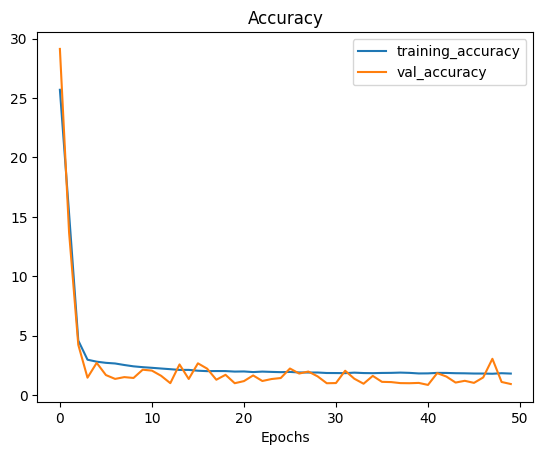

In [142]:
plot_loss_curves(history)

In [143]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_avg_Standard.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


# MANUAL TESTING ON RANDOM DATA

In [144]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 6, 1)
end = datetime.datetime(2024, 6, 30)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-06-01  34.5  30.0  41.6   0.0   NaN  203.0  14.7   NaN  1003.3   NaN
2024-06-02  34.5  30.0  41.4   0.0   NaN  212.0  10.9   NaN  1004.5   NaN
2024-06-03  34.8  30.0  41.6   0.0   NaN  220.0  11.6   NaN  1003.9   NaN
2024-06-04  34.8  30.0  41.4   0.0   NaN  227.0  15.0   NaN  1004.4   NaN
2024-06-05  34.5  29.0  41.4   0.0   NaN  223.0  14.3   NaN  1005.0   NaN
2024-06-06  34.6  29.0  41.6   0.0   NaN  227.0  12.6   NaN  1005.7   NaN
2024-06-07  35.7  30.0  42.4   0.0   NaN  248.0  12.0   NaN  1003.6   NaN
2024-06-08  35.5  31.0  41.8   0.0   NaN  224.0  11.0   NaN  1002.4   NaN
2024-06-09  35.6  29.0  43.0   0.0   NaN  267.0  13.1   NaN  1001.9   NaN
2024-06-10  32.5  27.4  39.6   1.0   NaN  234.0  10.1   NaN  1003.5   NaN
2024-06-11  33.3  25.5  40.2  30.0   NaN  250.0  10.7   NaN  1003.5   NaN
2024-06-12  33.5  29.0  40.8   0.0   N

In [145]:
print(data.shape)

(30, 10)


In [146]:
next_6_months_temp=data[target_column]


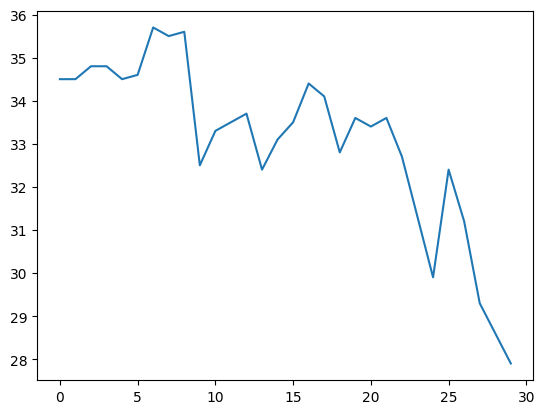

In [147]:
plt.plot(next_6_months_temp.values.flatten())

In [148]:
import datetime
location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 2, 22)
end = datetime.datetime(2024, 5, 31)

# Get historical data
data_for_model = Daily(location, start, end)
data_for_model = data_for_model.fetch()

print(data_for_model)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-02-22  24.2  20.0  29.8   0.0   NaN  266.0  10.0   NaN  1012.2   NaN
2024-02-23  22.6  15.0  30.0   0.0   NaN  347.0   5.7   NaN  1013.6   NaN
2024-02-24  22.1  14.0  30.0   0.0   NaN  327.0   6.7   NaN  1013.6   NaN
2024-02-25  22.4  13.0  30.6   0.0   NaN    6.0   9.5   NaN  1013.5   NaN
2024-02-26  23.9  19.0  30.0   0.0   NaN   29.0  11.7   NaN  1012.1   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-05-27  35.2  29.0  45.0   0.0   NaN  221.0  13.9   NaN   999.1   NaN
2024-05-28  34.4  29.0  43.4   0.0   NaN  214.0  15.5   NaN   999.5   NaN
2024-05-29  34.1  29.0  41.4   0.0   NaN  206.0  17.7   NaN   999.8   NaN
2024-05-30  34.3  30.0  43.0   0.0   NaN  201.0  13.6   NaN  1001.5   NaN
2024-05-31  34.4  30.0  42.4   0.0   NaN  198.0  15.7   NaN  1003.3   NaN

[100 rows x 10 columns]


In [149]:
data_for_model[target_column].values

array([24.2, 22.6, 22.1, 22.4, 23.9, 25.5, 25.8, 27.3, 28.7, 25.5, 20.1,
       20.7, 22.2, 23.5, 24.6, 25.1, 25.5, 26.2, 27.5, 27.7, 26.9, 27.1,
       26.8, 27.3, 28.9, 28.9, 28. , 29.2, 29.4, 28.9, 30.1, 29.7, 30.6,
       31.3, 32.4, 32.5, 31.7, 30. , 29.2, 30.1, 30.1, 30.2, 30.1, 30.5,
       31.1, 30.7, 32.1, 32.3, 33. , 32.2, 31.7, 31. , 31.4, 32.3, 33. ,
       34. , 34.6, 32.6, 31. , 31.1, 31.8, 32.2, 33.3, 33.7, 32.9, 32.7,
       33.3, 33.7, 33.1, 32.5, 32.6, 33.4, 34.5, 33.6, 33.4, 34.6, 34.8,
       34.7, 34.3, 34.6, 35.1, 32.5, 30.4, 33.2, 35.5, 36.3, 36.8, 37.6,
       37.4, 37.3, 37.5, 38. , 37.5, 36.1, 35.9, 35.2, 34.4, 34.1, 34.3,
       34.4])

In [150]:
data_for_model.reset_index(inplace=True)

data_for_model=data_for_model[["time",target_column]]

data_for_model['month'] = data_for_model['time'].dt.month
data_for_model['dayofyear'] = data_for_model['time'].dt.dayofyear  


seasonal_mean = data_for_model.groupby('month')[target_column].transform('mean') 
data_for_model[target_column] = data_for_model[target_column].fillna(seasonal_mean) 
data_for_model['sin_day_of_year'] = np.round(np.sin(2 * np.pi * data_for_model['dayofyear'] / 365),4)
data_for_model['cos_day_of_year'] = np.round(np.cos(2 * np.pi * data_for_model['dayofyear'] / 365),4)

data_for_model=data_for_model[[target_column,"sin_day_of_year","cos_day_of_year","month"]]

In [151]:
data_for_model

,tavg,sin_day_of_year,cos_day_of_year,month
0,24.2,0.7909,0.6119,2
1,22.6,0.8014,0.5982,2
2,22.1,0.8115,0.5843,2
3,22.4,0.8215,0.5702,2
4,23.9,0.8312,0.5560,2
...,...,...,...,...
95,35.2,0.5596,-0.8288,5
96,34.4,0.5452,-0.8383,5
97,34.1,0.5307,-0.8475,5
98,34.3,0.5161,-0.8566,5


In [152]:
data_for_model=Standard.transform(np.array(data_for_model.values).reshape(-1,1))


In [153]:
data_for_model=data_for_model.reshape(100,4)

In [103]:
data_for_model.shape

(100, 4)

In [ ]:
data_for_model

In [ ]:
# data_for_model=data_for_model.flatten()
# data_for_model

In [ ]:
Y_train[:10]

In [154]:
from datetime import datetime,timedelta

output=[]
base_date = datetime(2024, 5, 31)
for i in range(30):
    future_date = base_date + timedelta(days=i + 1)
    day_of_year = future_date.timetuple().tm_yday
    sin_day = np.round(np.sin(2 * np.pi * day_of_year / 365),4)
    cos_day = np.round(np.cos(2 * np.pi * day_of_year / 365),4)
    month = future_date.month
  
    
    prediction = best_model.predict(data_for_model.reshape(-1, window_size, 4), verbose=1)
    predicted_temp = prediction[0][0]
    print(prediction)
    output.append(predicted_temp)

    

 
    next_input = np.array([predicted_temp, sin_day, cos_day, month])
    next_input_scaled = Standard.transform(next_input.reshape(-1,1))
    data_for_model = np.vstack([data_for_model[1:], next_input_scaled.reshape(1,4)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
[[34.420776]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[34.354794]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[34.287888]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[34.226746]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[34.16871]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[34.112823]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[34.058342]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[34.006157]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[33.956974]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[33.91118]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[33.867718]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[33.825478]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[33.784653]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[33.74521]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[33.707115]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[33.670418]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[33.635197]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[33.601597]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[33.569725]]
1/1 ━━━━━━━━━━

In [155]:
next_6_months_temp=list(next_6_months_temp.values)

In [156]:
print("Len Output:",len(output))
print("Len next_6_months_temp:",len(next_6_months_temp))


Len Output: 30
Len next_6_months_temp: 30


In [ ]:
output

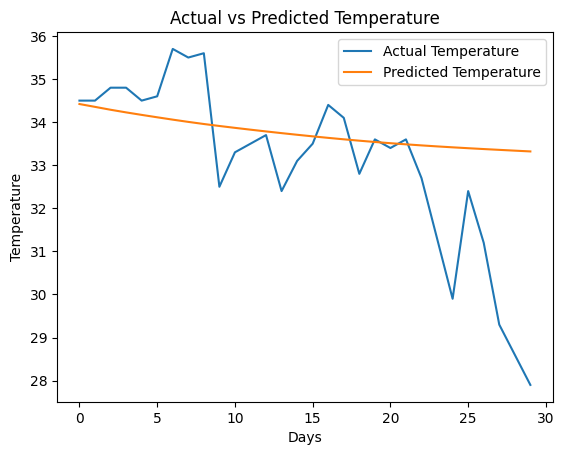

In [157]:

# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(list(next_6_months_temp), label="Actual Temperature")
plt.plot(list(np.array(output).flatten()), label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [158]:
from sklearn.metrics import r2_score,mean_squared_error
mean_squared_error(list(next_6_months_temp),list(np.array(output).flatten()))

3.539976460736595

In [165]:
import pickle as pkl

pkl.dump(Standard,open("Standard_Scaler_avg.pkl",'wb'))

# EVALUTION 

In [160]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error


In [161]:
def model_evaluation(y_true, y_pred):
    """Compute evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    medianae=median_absolute_error(y_true,y_pred)
    
    
    metrics = {
        "Mean Sqaured Error": mse,
        "Mean Absolute Error": mae,
        "Median Absolute Error": medianae
    }
    return metrics

In [162]:
def display_metrics(metrics, save_path=None):
    """Stylishly display metrics using Matplotlib and optionally save the plot."""
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.barh(list(metrics.keys()), list(metrics.values()), color="skyblue")
    ax.set_title("Model Evaluation Metrics", fontsize=16, fontweight="bold")
    ax.set_xlabel("Scores", fontsize=12)
    ax.set_xlim(0, 4)
    for i, v in enumerate(metrics.values()):
        ax.text(v + 0.01, i, f"{v:.2f}", color="black", va="center", fontsize=10)
    plt.tight_layout()
    
    # Save the plot if a save path is provided
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Metrics plot saved to {save_path}")
    plt.show()

In [163]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,4))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Metrics plot saved to Matrix_Evalution_avg.png


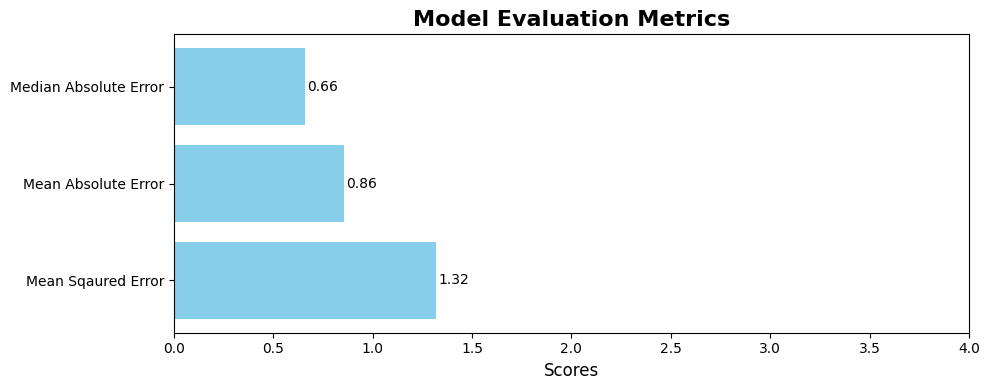

In [164]:
display_metrics(model_evaluation(Y_test,y_prediction_x),"Matrix_Evalution_avg.png")

In [ ]:
r2_score(Y_test[:30],y_prediction_x[:30])

## ALL MODEL EVALUTION

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error


In [ ]:
from meteostat import Point, Daily
import datetime

def prepare_data(feature,scaler):    
    location = Point( 23.0215374, 72.5800568)
    start = datetime.datetime(1990, 6, 1)
    end = datetime.datetime(2024, 6, 1)
    
    # Get historical data
    data = Daily(location, start, end)
    data = data.fetch()
    
    
    temperature_avg=data[feature]
    print("TOTAL NULL VALUES IN DATASET:",temperature_avg.isnull().sum())
    temperature_avg.dropna(inplace=True)
    
    temperature_avg_seq=temperature_avg.values
    print(temperature_avg_seq,temperature_avg_seq.shape)
    
    
    
    window_size=100
    
    X=[]
    Y=[]
    for i in range(len(temperature_avg_seq)-window_size):
      X.append(temperature_avg_seq[i:i+window_size])
      Y.append(temperature_avg_seq[i+window_size])
    
    X=np.array(X)
    Y=np.array(Y)

    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

    print("X_train Shape",X_train.shape)
    print("X_test Shape",X_test.shape)
    print("Y_train Shape",Y_train.shape)
    print("Y_test Shape",Y_test.shape)


    X_train_Scaled=scaler.transform(X_train.reshape(-1,1))
    X_test_Scaled=scaler.transform(X_test.reshape(-1,1))

    X_train=X_train_Scaled.reshape(X_train.shape[0],100)
    X_test=X_test_Scaled.reshape(X_test.shape[0],100)

    
    print("AFTER SCALED")
    print("X_train Shape",X_train.shape)
    print("X_test Shape",X_test.shape)
    print("Y_train Shape",Y_train.shape)
    print("Y_test Shape",Y_test.shape)
    




    
    return X_train,X_test,Y_train,Y_test

In [ ]:
def model_evaluation(y_true, y_pred):
    """Compute evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    medianae=median_absolute_error(y_true,y_pred)
    
    
    metrics = {
        "Mean Sqaured Error": mse,
        "Mean Absolute Error": mae,
        "Median Absolute Error": medianae
    }
    return metrics

In [ ]:

def display_all_metrics(metrics_dicts, features):
   
    fig, ax = plt.subplots(figsize=(12, 6))
 
    num_groups = len(metrics_dicts)
    bar_width = 0.15
    indices = np.arange(len(metrics_dicts[0])) 
    
    
    for i, (metrics, feature) in enumerate(zip(metrics_dicts, features)):
        bar_positions = indices + i * bar_width
        ax.barh(bar_positions, list(metrics.values()), bar_width, label=feature)
 
        for j, v in enumerate(metrics.values()):
            ax.text(v + 0.01, bar_positions[j], f"{v:.2f}", va="center", fontsize=9)
    
 
    ax.set_title("Model Evaluation Metrics", fontsize=16, fontweight="bold")
    ax.set_xlabel("Scores", fontsize=12)
    ax.set_xlim(0, 4) 
    ax.set_yticks(indices + (num_groups - 1) * bar_width / 2)
    ax.set_yticklabels(metrics_dicts[0].keys(), fontsize=10)
    ax.legend(loc="best", title="Feature Sets", fontsize=10)
    
    plt.tight_layout()
    plt.show()


## 1. TEMPERATURE AVERAGE

## MIN MAX SCALER

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_avg_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
MinMax_Avg=pkl.load(open("/kaggle/working/MinMax_Avg_MinMax.pkl","rb"))

In [ ]:
X_train,X_test,Y_train,Y_test=prepare_data("tavg",MinMax_Avg)

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
y_prediction_x[0],Y_test[0]

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))

temp_avg_minmax=model_evaluation(Y_test,y_prediction_x)

## STANDARD SCALER

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_avg.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
Standard_Avg=pkl.load(open("/kaggle/working/MinMax_Avg.pkl","rb"))

In [ ]:
X_train,X_test,Y_train,Y_test=prepare_data("tavg",Standard_Avg)

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_avg_Standard=model_evaluation(Y_test,y_prediction_x)

# 2.TEMPERATURE MINIMUM 

## 1.MINMAX SCALER 

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_min_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
MinMax_Avg=pkl.load(open("/kaggle/working/MinMaxScaler_min.pkl","rb"))

In [ ]:
X_train,X_test,Y_train,Y_test=prepare_data("tmin",MinMax_Avg)

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))



temp_min_minmax=model_evaluation(Y_test,y_prediction_x)

## 2. Standard Scaler

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_min_StandardScaler.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
Standard_Avg=pkl.load(open("/kaggle/working/StandardScaler_min.pkl","rb"))

In [ ]:
X_train,X_test,Y_train,Y_test=prepare_data("tmin",Standard_Avg)

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_min_Standard=model_evaluation(Y_test,y_prediction_x)

# 3.TEMPERATURE MAX

## 1. MinMax Scaler

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_max_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
MinMax_Max=pkl.load(open("/kaggle/working/MinMax_Max.pkl","rb"))

In [ ]:
X_train,X_test,Y_train,Y_test=prepare_data("tmax",MinMax_Max)

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_max_minmax=model_evaluation(Y_test,y_prediction_x)

## 2. Standard Scaler

In [ ]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_max_StandardScaler.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [ ]:
Standard_Max=pkl.load(open("/kaggle/working/StandardScaler.pkl","rb"))

In [ ]:
X_train,X_test,Y_train,Y_test=prepare_data("tmax",Standard_Max)

In [ ]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_max_standard=model_evaluation(Y_test,y_prediction_x)

## VISUAL

In [ ]:
metrics_dicts = [
    temp_avg_minmax, temp_avg_Standard,
    temp_min_minmax, temp_min_Standard,
    temp_max_minmax, temp_max_standard
]
features = [
    "Temperature Average MinMax", "Temperature Average Standard",
    "Temperature MiniMum MinMax", "Temperature MiniMum Standard",
    "Temperature Maximum MinMax", "Temperature Maximum Standard"
]

# Display all metrics in a single plot
display_all_metrics(metrics_dicts, features)

 <h1 style="text-align:center;">END</h1>

---